# Test functions that automatically find the circles in a fits file image in order to identify the beam center and radius. 

In [ ]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import glob
# sys.path.insert(0, 'C:\\Users\\EPL User\\Documents\\GitHub\wcmelby-HWP_Characterizations\\operational_scripts')
sys.path.insert(0, '../../operational_scripts')

from New_DRRP_Functions import dark_subtract, find_pixels, extract_intensities, q_ultimate_polarimetry, I_ultimate_polarimetry
# from New_DRRP_Functions import *

In [ ]:
# through stokes and exoserver
img_file = '/home/shared/exoserver/Lab_Data/Mueller_Matrix_Polarimeter/L_Plate_Characterization/SuperK_Select_Data/Calibrations/Calibration_Reduced/SK_Cal_1100_Reduced/Reduced_DRRP_Cal_1100nm_490_2_151.9999072265625.fits'

In [ ]:
img_file = r"D:\desktop_drrp_data\test_12_17_2024\darks\-40C_tint_1_FPS_10.fits"
find_pixels(img_file)

In [ ]:
# old version

def find_circles(img_directory):
    """
    Find the center and radius of a circular bright spot.
    """
    img_files = glob.glob(os.path.join(img_directory, '*'))
    img_file = img_files[2]  # take the third image, which should be a good example
    print(img_file)

    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        # try to do median if it's a cube
        # img_data = np.median(img_data, axis=0)
        hdul.close()

    # Step 1: Check the shape of the image data
    print(f"Image data shape: {img_data.shape}")
    
    # Step 2: Preprocess the image (apply thresholding or smoothing)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_data.astype(np.uint8))
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)
    
    # Step 4: Threshold the image (adjust thresholding for faint circles)
    _, thresholded_image = cv2.threshold(blurred_image, np.max(blurred_image) * 0.3, 255, cv2.THRESH_BINARY)

    # Step 5: Apply Hough Circle Transform with adjusted parameters
    circles = cv2.HoughCircles(thresholded_image.astype(np.uint8),
                               cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=100, param2=20, minRadius=10, maxRadius=100)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        
        for circle in circles:
            center = (circle[0], circle[1])
            radius = circle[2]
            print(f"Circle center: {center}, radius: {radius}")
            
            # Optionally, draw the circle
            output_image = img_data.copy()
            cv2.circle(output_image, center, radius, (0, 255, 0), 4)  # Draw the circle
            cv2.rectangle(output_image, (center[0] - 5, center[1] - 5),
                          (center[0] + 5, center[1] + 5), (0, 128, 255), -1)  # Draw the center
            
            # Display the result with origin at the lower left
            plt.imshow(output_image, cmap='gray', origin='lower')
            plt.show()
    else:
        print("No circles detected.")


In [ ]:
# version that plots in yellow

def find_circles(img_directory):
    """
    Find the center and radius of a circular bright spot and overlay the detected circle and center in yellow.
    """
    img_files = glob.glob(os.path.join(img_directory, '*'))
    img_file = img_files[2]  # take the third image
    print("Using image:", img_file)

    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        hdul.close()

    print(f"Image data shape: {img_data.shape}")

    # Directly cast to uint8 if the image is already in a roughly 0-255 range.
    if img_data.dtype != np.uint8:
        img_data = img_data.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_data)
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)

    # You might adjust the threshold multiplier if needed.
    _, thresholded_image = cv2.threshold(blurred_image, np.max(blurred_image) * 0.3, 255, cv2.THRESH_BINARY)

    circles = cv2.HoughCircles(thresholded_image,
                               cv2.HOUGH_GRADIENT, dp=1.2, minDist=30,
                               param1=100, param2=20, minRadius=10, maxRadius=100)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        circles = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        output_image = cv2.cvtColor(img_data, cv2.COLOR_GRAY2BGR)
        
        for circle in circles:
            center = (circle[0], circle[1])
            radius = circle[2]
            print(f"Circle center: {center}, radius: {radius}")
            cv2.circle(output_image, center, radius, (0, 255, 255), 4)
            cv2.rectangle(output_image, (center[0] - 5, center[1] - 5),
                          (center[0] + 5, center[1] + 5), (0, 255, 255), -1)
        
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB), origin='lower')
        plt.title("Detected Circles")
        plt.show()
    else:
        print("No circles detected.")

In [ ]:
def find_two_largest_circles(img_directory):
    """
    Detect circles in the image using HoughCircles, select the two largest circles,
    and print their centers and radii.
    """
    # Get list of image files and choose the third image.
    img_files = glob.glob(os.path.join(img_directory, '*'))
    if len(img_files) < 3:
        print("Not enough images found in the directory.")
        return

    img_file = img_files[2]
    print("Using image:", img_file)

    # Open the FITS file.
    with fits.open(img_file) as hdul:
        img_data = hdul[0].data
        hdul.close()

    print("Original image shape:", img_data.shape)

    # Convert the image to 8-bit.
    # Option 1: Direct casting if the image is already near 0-255.
    # Uncomment the following line if you believe the original data is in that range:
    img_uint8 = img_data.astype(np.uint8)
    
    # Option 2: Normalize to the full 0-255 range, then convert.
    img_norm = cv2.normalize(img_data, None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_norm.astype(np.uint8)

    # Apply CLAHE to enhance contrast.
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(img_uint8)

    # Apply Gaussian blur.
    blurred_image = cv2.GaussianBlur(enhanced_image, (15, 15), 0)

    # Threshold the image.
    # You may need to adjust the multiplier (0.3) depending on your image.
    thresh_value = np.max(blurred_image) * 0.3
    ret, thresholded_image = cv2.threshold(blurred_image, thresh_value, 255, cv2.THRESH_BINARY)
    print("Threshold value used:", thresh_value)
    
    # Uncomment the following lines to inspect the thresholded image:
    import matplotlib.pyplot as plt
    plt.imshow(thresholded_image, cmap='gray')
    plt.title("Thresholded Image")
    plt.show()
    
    # Use Hough Circle Transform to detect circles.
    circles = cv2.HoughCircles(
        thresholded_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=100,
        param2=20,
        minRadius=10,
        maxRadius=100
    )

    if circles is not None:
        # Convert the (x, y, r) values to integers.
        circles = np.round(circles[0, :]).astype("int")
        print("Total circles detected:", len(circles))
        
        # Sort circles by radius in descending order and select the two largest.
        circles_sorted = sorted(circles, key=lambda x: x[2], reverse=True)[:2]
        
        for i, circle in enumerate(circles_sorted, start=1):
            x, y, r = circle
            print(f"Circle {i}: Center = ({x}, {y}), Radius = {r}")
    else:
        print("No circles detected.")

Using image: D:\desktop_drrp_data\test_12_17_2024\calibration\calibration_raw\Cal_1600_Reduced\Reduced_DRRP_JHK_1600nm_FPS_10_tint_1_QWP1_position_104_QWP2_position_520.fits
Image data shape: (512, 640)
Circle center: (223, 211), radius: 98
Circle center: (355, 241), radius: 95


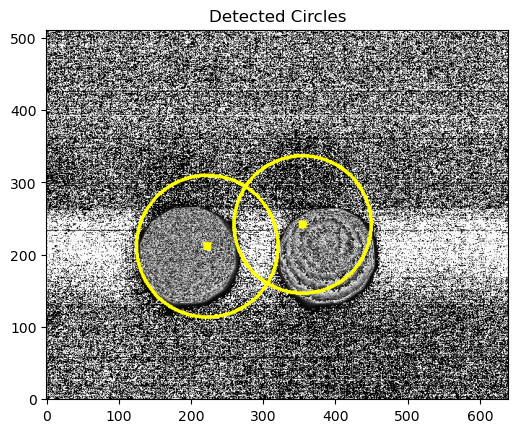

In [ ]:
# try to work with the third image in the folder
img_directory = r"D:\desktop_drrp_data\test_12_17_2024\calibration\calibration_raw\Cal_1600_Reduced"
find_circles(img_directory)